In [1]:
!git clone https://github.com/darshan154/db2.git

Cloning into 'db2'...
remote: Enumerating objects: 6624, done.
remote: Counting objects: 100% (6624/6624), done.
remote: Compressing objects: 100% (6525/6525), done.
remote: Total 6624 (delta 136), reused 6586 (delta 98), pack-reused 0
Receiving objects: 100% (6624/6624), 9.88 MiB | 26.77 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from numpy import asarray
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [3]:
from PIL import Image
import glob
data = []
for filename in glob.glob(r"./db2/data/" + "/**/*", recursive=True): #assuming gif
    # im=Image.open(filename)
    data.append(filename)

In [4]:
label = {"anchor":0, "athlete":1, "doctor":2, "farmer":3, "professor": 4}

In [5]:
y = []
x = []
for img in data:
  try:
    image = cv2.imread(img)
    image = cv2.resize(image, (64, 64))
    image = img_to_array(image)
    x.append(image)

    lbl = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    l = label[lbl]
        
    y.append([l]) # [[1], [0], [0], ...]

  except:
    print("Corrupt")

Corrupt
Corrupt
Corrupt
Corrupt
Corrupt


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [7]:
trainx = np.array(X_train, dtype="float")/255.0
testx = np.array(X_test, dtype="float")/255.0
trainy = np.array(y_train)
testy = np.array(y_test)

In [8]:
# # example of tending the vgg16 model
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import math
# load model without classifier layers
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))

win1 = math.ceil(16/1)
str1 = math.floor(16/1)

win2 = math.ceil(16/2)
str2 = math.floor(16/2)

win3 = math.ceil(16/4)
str3 = math.floor(16/4)

win4 = math.ceil(16/8)
str4 = math.floor(16/8)

l1 = keras.layers.MaxPooling2D(pool_size=(win1), strides=str1, padding="valid")(base_model.layers[-12].output)
l2 = keras.layers.MaxPooling2D(pool_size=(win2), strides=str2, padding="valid")(base_model.layers[-12].output)
l3 = keras.layers.MaxPooling2D(pool_size=(win3), strides=str3, padding="valid")(base_model.layers[-12].output)
# l4 = keras.layers.MaxPooling2D(pool_size=(win4), strides=str4, padding="valid")(base_model.layers[-10].output)



flat1 = Flatten()(l1)
flat2 = Flatten()(l2)
flat3 = Flatten()(l3)
# flat4 = Flatten()(l4)

# class1 = Dense(4096, activation='relu')(flat1)
# # define new model

for layer in base_model.layers:
    layer.trainable = False


model = Model(inputs=base_model.inputs, outputs=[flat1, flat2, flat3])

# combined = np.concatenate([b1.output, b2.output, b3.output])

58900480/58889256 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

In [11]:
svc=SVC(probability=True, kernel="linear")
clf = AdaBoostClassifier(n_estimators=21, base_estimator=svc, learning_rate=0.5)

In [12]:
train = model.predict(trainx)
test = model.predict(testx)

In [13]:
train = np.hstack([train[0], train[1], train[2]])
test = np.hstack([test[0], test[1], test[2]])

In [14]:
train.shape

(750, 5376)

In [15]:
clfmodel = clf.fit(train, trainy)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
y_pred = clfmodel.predict(test)

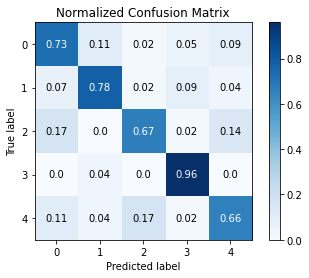

In [17]:
!pip install scikit-plot
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt
#Normalized confusion matrix for the K-NN model
skplt.metrics.plot_confusion_matrix(testy, y_pred, normalize=True)
plt.show()


In [18]:
# accuray = 76